In [2]:
import numpy as np
training_steps_per_increment = [6000, 5500, 5100, 4800, 4600, 4300, 4100, 3900, 3700, 3600]
            # self.training_steps_per_increment = [1 for _ in range(10)]  # For testing
np.cumsum(training_steps_per_increment).tolist()

[6000, 11500, 16600, 21400, 26000, 30300, 34400, 38300, 42000, 45600]

Comparing 30 image pairs from index 0 to 29


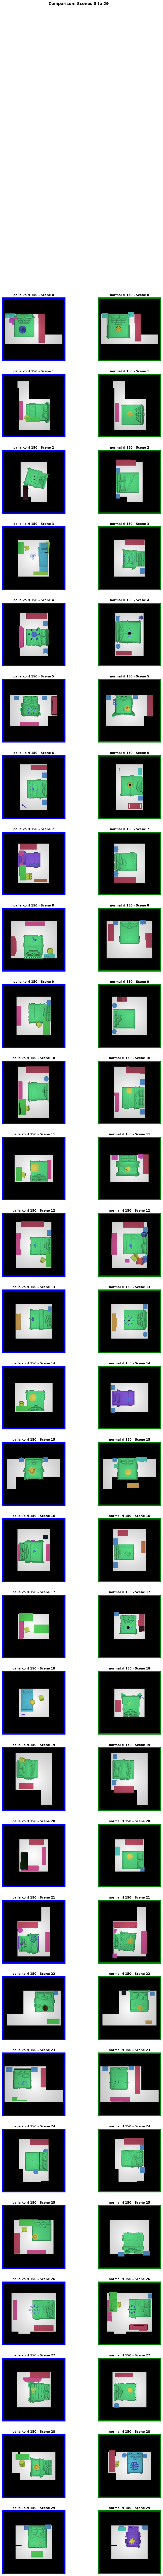

In [5]:
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

def compare_two_dirs(dir1, dir2, start_idx=1, end_idx=None, dir1_name= "Dir 1", dir2_name= "Dir 2", images_per_row=2):
    """
    Compare images from two directories side by side.
    
    Args:
        dir1 (str): First directory path
        dir2 (str): Second directory path
        start_idx (int): 1-based start index (inclusive)
        end_idx (int): 1-based end index (inclusive). None = all remaining
        images_per_row (int): Images per row (default 2 for side-by-side)
    """
    # Get sorted PNG files from both directories
    files1 = sorted([f for f in os.listdir(dir1) if f.lower().endswith('.png')])
    files2 = sorted([f for f in os.listdir(dir2) if f.lower().endswith('.png')])
    
    if not files1 or not files2:
        print("No PNG images found in one or both directories.")
        return
    
    # Convert 1-based indices to 0-based
    start0 = start_idx 
    end0 = end_idx if end_idx is not None else max(len(files1), len(files2))
    
    # Select files in range
    selected1 = files1[start0:end0]
    selected2 = files2[start0:end0]
    
    num_pairs = min(len(selected1), len(selected2))
    print(f"Comparing {num_pairs} image pairs from index {start_idx} to {start_idx + num_pairs - 1}")
    if num_pairs == 0:
        print("No images in requested range.")
        return
    
    # Create grid: num_pairs rows, 2 columns
    fig, axes = plt.subplots(num_pairs, 2, figsize=(12, 5 * num_pairs))
    
    if num_pairs == 1:
        axes = axes.reshape(1, -1)
    
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    
    for i in range(num_pairs):
        # Left image
        img1 = Image.open(os.path.join(dir1, selected1[i]))
        img1 = ImageOps.expand(img1, border=5, fill='blue')
        axes[i, 0].imshow(img1)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"{dir1_name} - Scene {start_idx + i}", fontsize=11, fontweight='bold')
        
        # Right image
        img2 = Image.open(os.path.join(dir2, selected2[i]))
        img2 = ImageOps.expand(img2, border=5, fill='green')
        axes[i, 1].imshow(img2)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"{dir2_name} - Scene {start_idx + i}", fontsize=11, fontweight='bold')
    
    fig.suptitle(f"Comparison: Scenes {start_idx} to {start_idx + num_pairs - 1}", 
                 fontsize=14, fontweight='bold')
    plt.show()

# input1 = "/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-12-12/13-11-59/" # 10 steps
# input1 = "/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-12-12/13-29-22" # 15 steps
# input1 = "/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-12-12/13-38-01/" # 200 steps
input1 = "/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-12-25/07-53-45/" # ver 10

# input2 = "/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-12-25/07-47-28"
# input2 = "/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-12-12/12-40-52/" # baseline 
# # input2 = "/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-12-11/04-26-15/"
input2 = "/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-12-25/13-02-51/"

# Usage with your directories
compare_two_dirs(input1, input2, dir1_name="paila ko rl 150", dir2_name="normal rl 150", start_idx=0, end_idx=30)

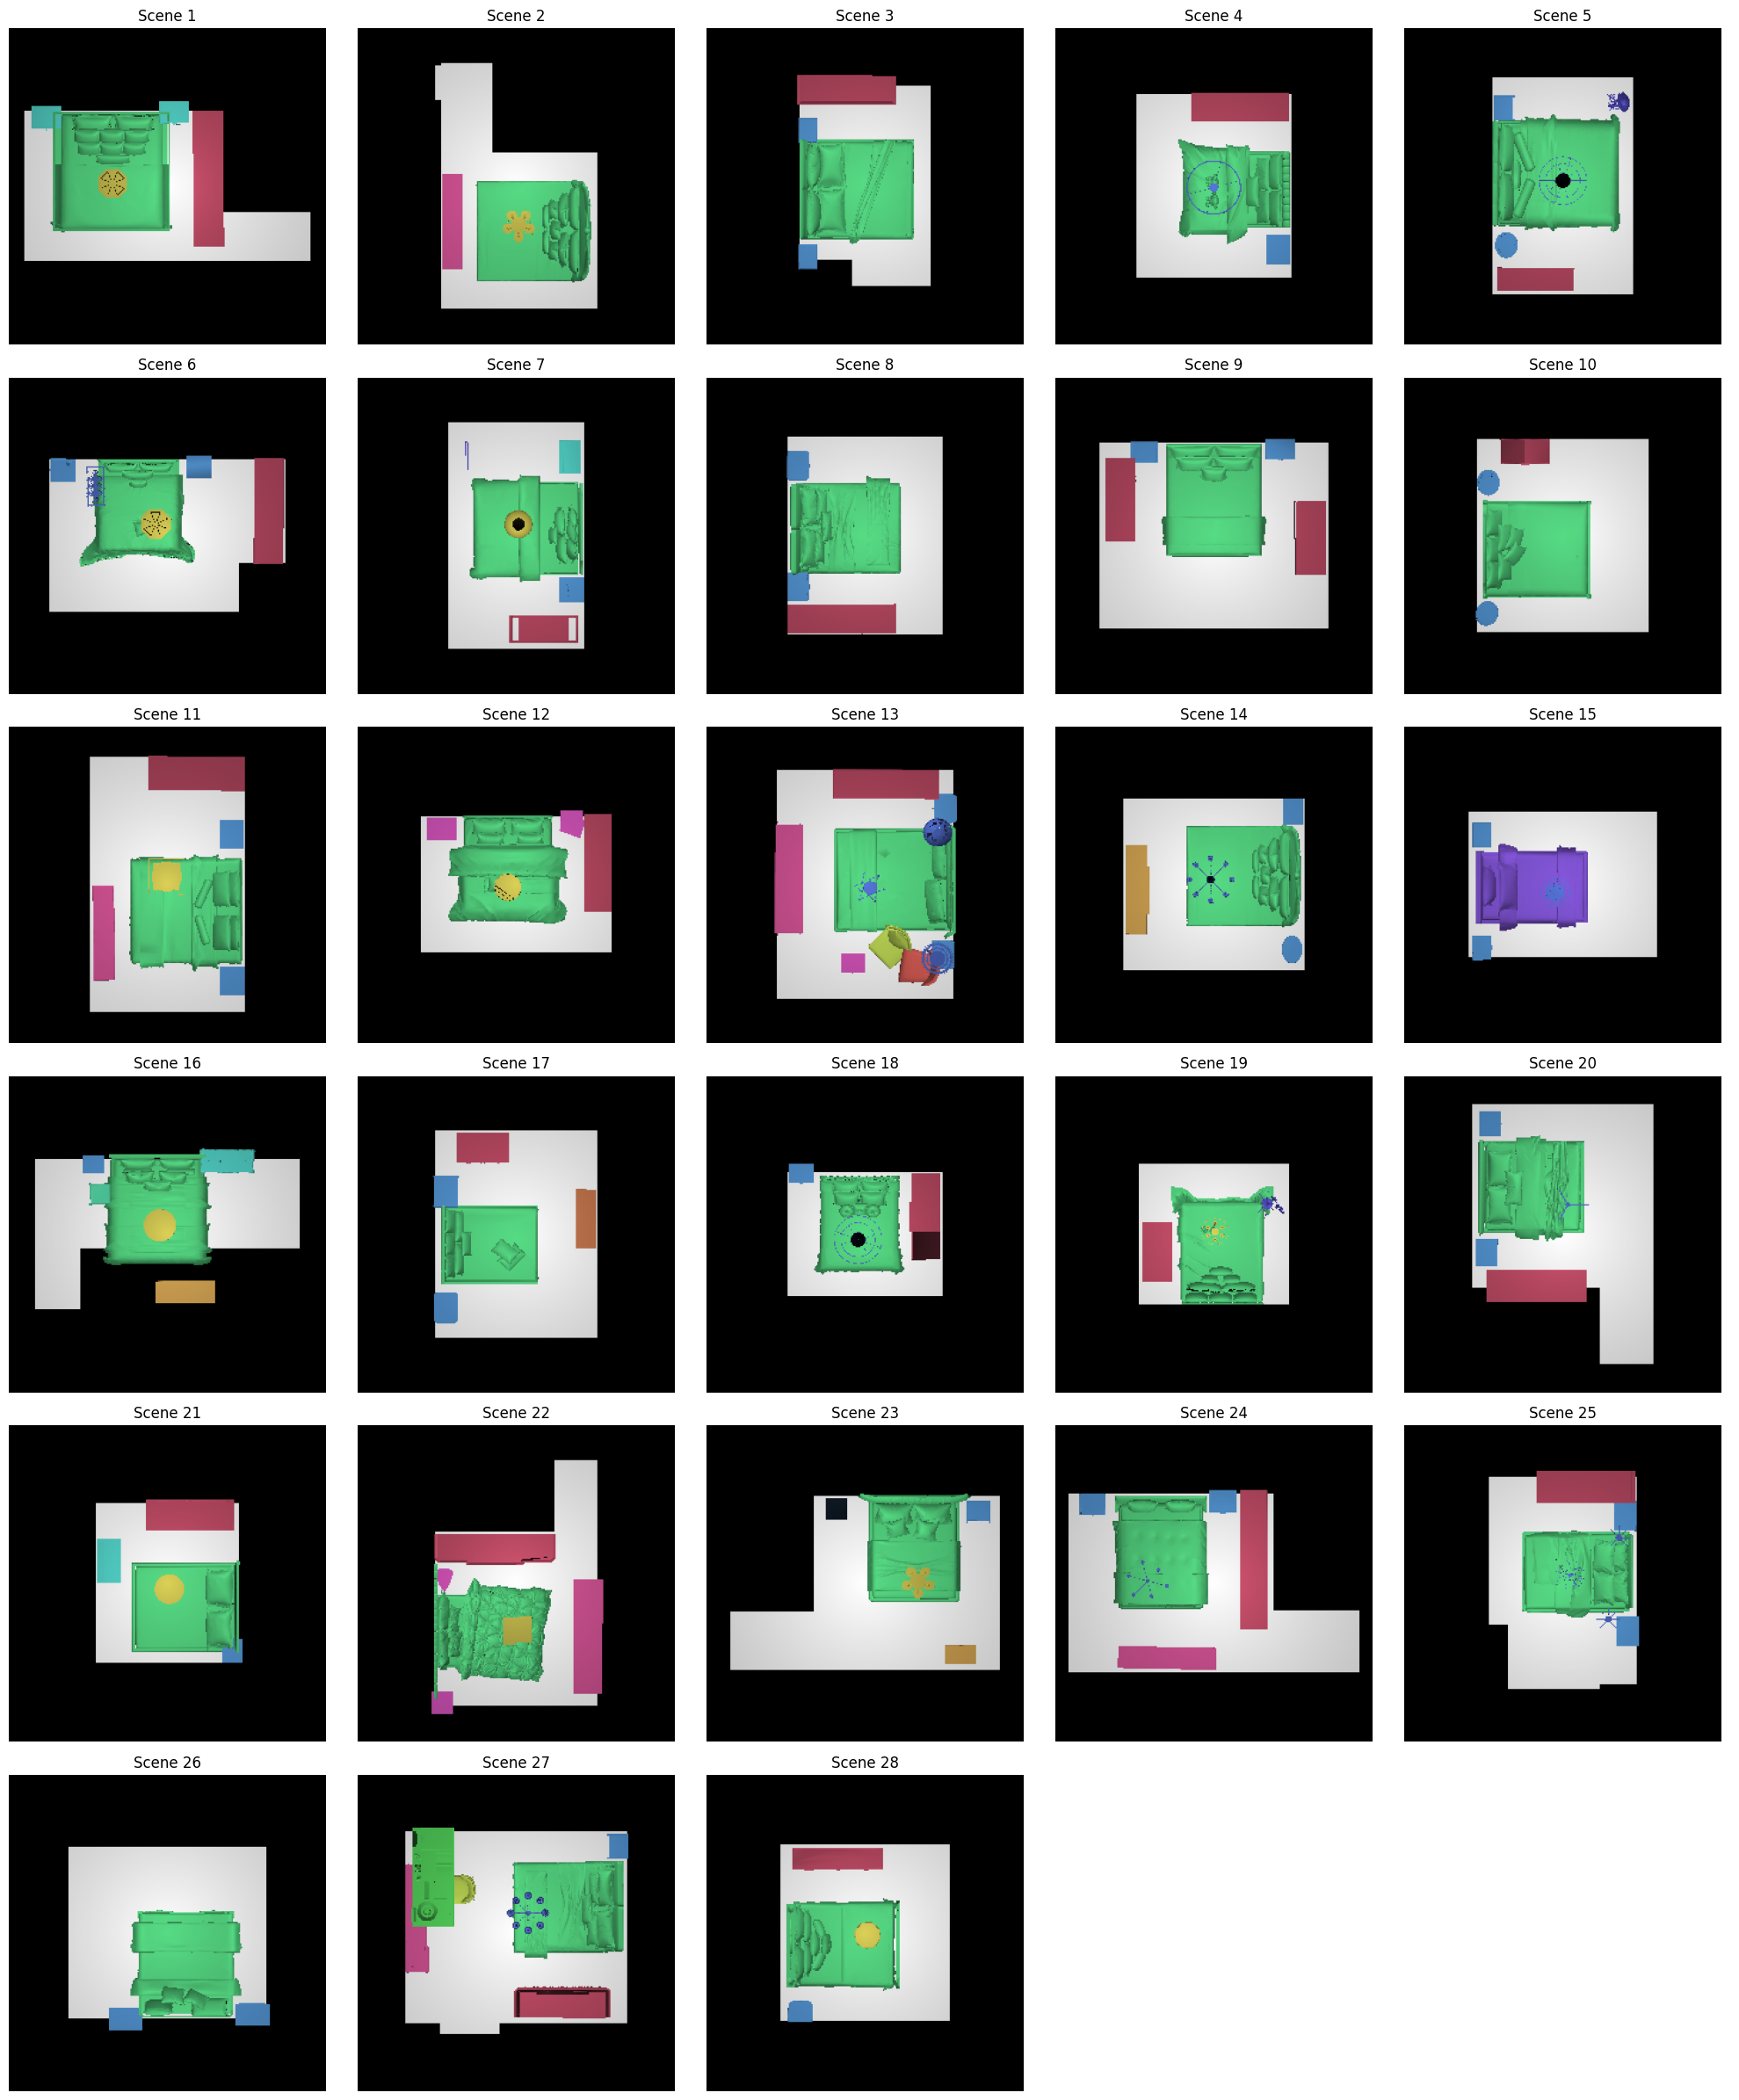

In [14]:
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

def show_image_collage(img_dir, images_per_row=5, max_rows=3, start_idx=1, end_idx=None):
    """
    Display a collage of PNG images from a directory in a grid, with a black frame around each image.
    Args:
        img_dir (str): Directory containing PNG images.
        images_per_row (int): Number of images per row.
        max_rows (int): Maximum number of rows to display.
        start_idx (int): 1-based start index of images to show (inclusive).
        end_idx (int or None): 1-based end index of images to show (inclusive). None => until available/max limit.
    """
    # Get sorted list of PNG files
    img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith('.png')])
    if not img_files:
        print("No PNG images found in directory.")
        return

    # Convert 1-based args to 0-based slicing
    if start_idx < 1:
        print("start_idx must be >= 1")
        return
    start0 = start_idx - 1
    end0 = None
    if end_idx is not None:
        if end_idx < start_idx:
            print("end_idx must be >= start_idx")
            return
        end0 = end_idx  # slicing end is exclusive when used below, so keep as end_idx

    selected = img_files[start0:end0]
    if not selected:
        print("No images in the requested range.")
        return

    max_images = images_per_row * max_rows
    selected = selected[:max_images]  # cap to display limit

    num_images = len(selected)
    num_rows = (num_images + images_per_row - 1) // images_per_row

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(4 * images_per_row, 4 * num_rows))
    # flatten axes into a list for easy indexing
    if num_rows == 1 and images_per_row == 1:
        axes_list = [axes]
    elif num_rows == 1:
        axes_list = list(axes)
    else:
        axes_list = [axes[r][c] for r in range(num_rows) for c in range(images_per_row)]

    for idx, img_file in enumerate(selected):
        ax = axes_list[idx]
        img = Image.open(os.path.join(img_dir, img_file))
        img = ImageOps.expand(img, border=5, fill='black')  # Add black frame
        ax.imshow(img)
        ax.axis('off')
        # Scene numbering uses the original 1-based index in the directory list
        scene_number = start0 + idx + 1
        ax.set_title(f"Scene {scene_number}", fontsize=12)

    # Hide unused subplots
    total_slots = images_per_row * num_rows
    for idx in range(num_images, total_slots):
        axes_list[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Example usages:
# show_image_collage("/path/to/dir", images_per_row=5, max_rows=3, start_idx=1, end_idx=15)
# show_image_collage("/path/to/dir", start_idx=6, end_idx=20)

# Current call (keeps previous behavior, can pass start_idx/end_idx as needed)
# show_image_collage("/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-11-03/13-25-12/", start_idx=15, end_idx=1000)
# show_image_collage("/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-11-04/13-13-25/", start_idx=1, end_idx=1000)
# show_image_collage("/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-11-07/17-12-03/", start_idx=1, end_idx=1000, max_rows=10)python ../ThreedFront/scripts/render_results.py --no_texture --retrieve_by_size /media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-11-09//sampled_scenes_results.pkl
show_image_collage("/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-12-26/20-46-07/", start_idx=1, end_idx=50, images_per_row = 5, max_rows=30)

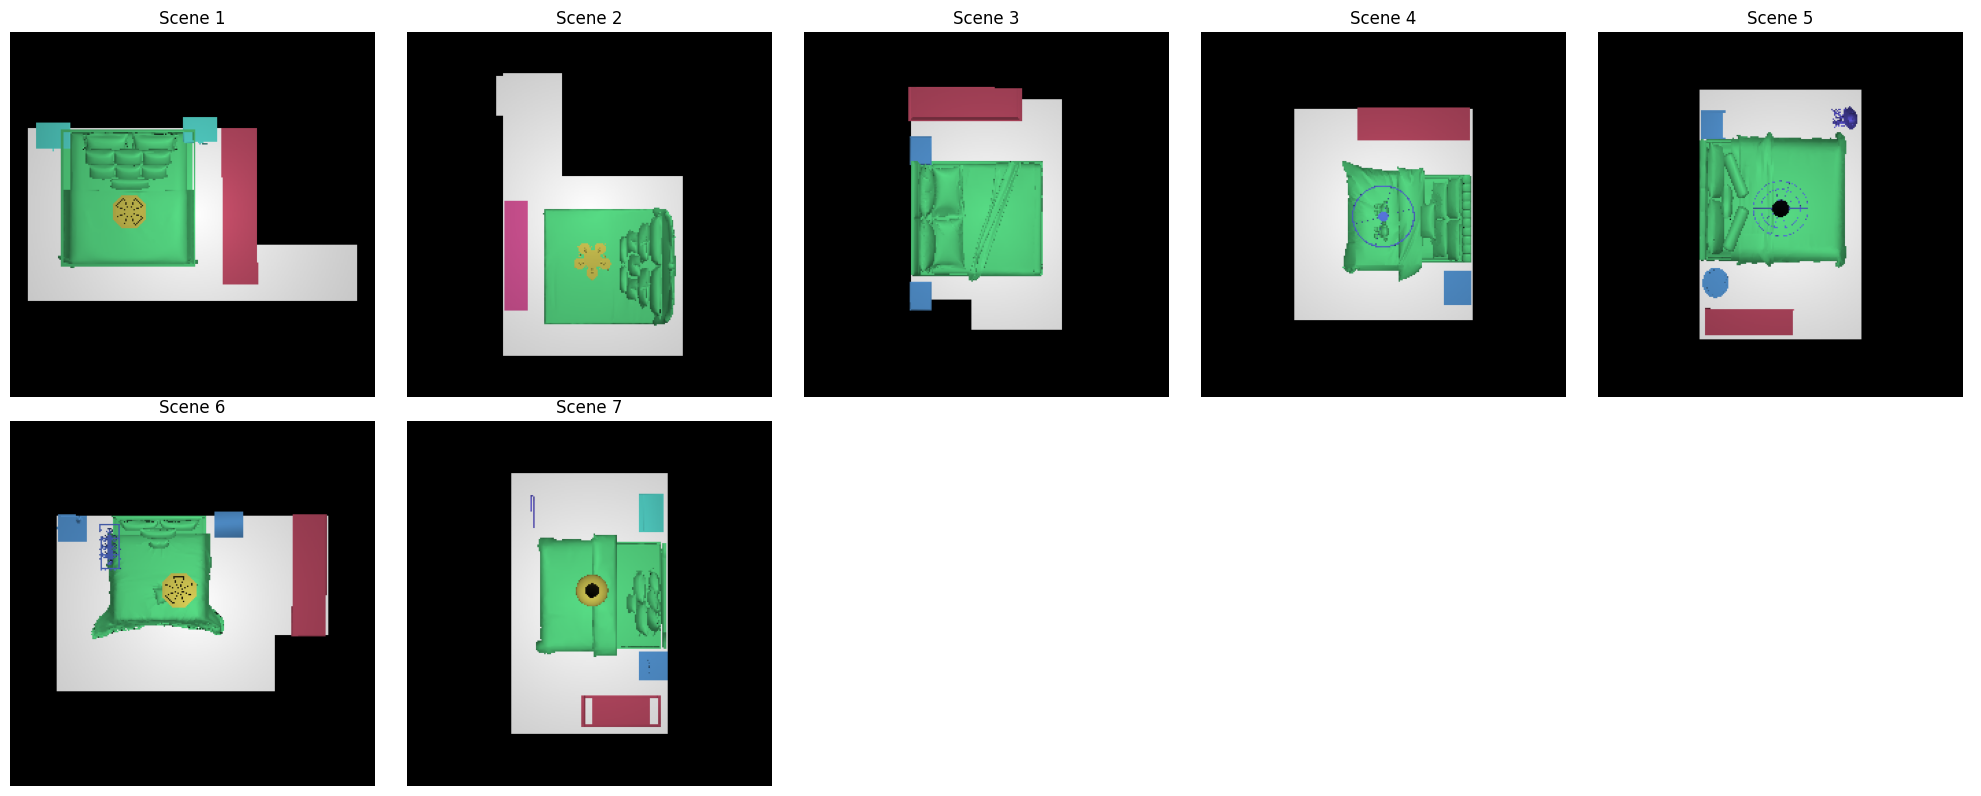

In [3]:
show_image_collage("/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-12-25/13-02-51/", start_idx=1, end_idx=50, images_per_row = 5, max_rows=30)

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

# YOUR ACTUAL DATA (256 scenes)
real_rewards = np.array([4.9868e-01, ])

import matplotlib.pyplot as plt
import numpy as np

def plot_and_zscore(data_list):
    """
    Takes a Python list, plots it as a line chart, applies z-score normalization,
    and plots the normalized data.
    
    Parameters:
    data_list (list): Input list of numerical values
    
    Returns:
    tuple: (normalized_array, mean, std)
    """
    # Convert list to numpy array for easier calculations
    x = np.array(data_list)
    
    # Plot original data
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, marker='o', linestyle='-', linewidth=2)
    plt.title('Original Data', fontsize=14, fontweight='bold')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    
    # Apply z-score normalization
    mean = x.mean()
    std = x.std()
    normalized = (x - mean) / std
    
    # Plot normalized data
    plt.subplot(1, 2, 2)
    plt.plot(normalized, marker='o', linestyle='-', linewidth=2, color='orange')
    plt.title('Z-Score Normalized Data', fontsize=14, fontweight='bold')
    plt.xlabel('Index')
    plt.ylabel('Z-Score')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Mean (0)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return normalized, mean, std


# Example usage:
if __name__ == "__main__":
    # Sample dat
    data = real_rewards.tolist()    
    # normalized_data, mean_val, std_val = plot_and_zscore(data)
    
    # print(f"Mean: {mean_val:.2f}")
    # print(f"Standard Deviation: {std_val:.2f}")
    # print(f"Normalized data: {normalized_data}")

In [ ]:
show_image_collage("/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-11-08/19-32-48", start_idx=1, end_idx=1000)

In [ ]:
show_image_collage("/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-11-02/10-02-44/", start_idx=1, end_idx=1000, max_rows=10)

In [ ]:
# show_image_collage("/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-10-27/17-57-19/", start_idx=40, end_idx=1000)

In [ ]:
import numpy as np
array = np.array([-1.7765e-04, -7.8288e-05, -8.1266e-05, -7.6261e-05, -6.3226e-05,
        -0.0000e+00, -8.6164e-04, -4.5090e-04, -0.0000e+00, -1.4092e-02,
        -4.6641e-04, -7.1494e-03, -1.2915e-05, -1.3934e-04, -5.8714e-06,
        -1.4898e-05, -8.1498e-03, -3.9654e-06, -6.1707e-05, -2.6419e-05,
        -0.0000e+00, -6.1526e-04, -6.0976e-05, -5.5456e-05, -1.2875e-04,
        -6.8270e-06, -5.7767e-04, -4.0453e-05, -4.6428e-04, -1.0434e-04,
        -4.2636e-04, -8.4839e-04, -8.5774e-05, -4.0658e-05, -0.0000e+00,
        -7.6695e-03, -5.1991e-05, -2.3217e-04, -1.3441e-05, -0.0000e+00,
        -9.0743e-04, -1.1201e-04, -0.0000e+00, -3.6841e-04, -1.1779e-04,
        -7.1738e-05, -0.0000e+00, -1.6401e-05, -0.0000e+00, -0.0000e+00,
        -6.6225e-05, -1.2669e-04, -8.2223e-04, -2.1495e-05, -2.6251e-04,
        -2.9722e-05, -2.3138e-05, -2.4605e-04, -0.0000e+00, -1.6640e-05,
        -0.0000e+00, -4.8851e-04, -7.6218e-04, -0.0000e+00, -0.0000e+00,
        -5.9510e-05, -3.1702e-04, -7.5637e-04, -5.6020e-03, -1.8832e-04,
        -4.1523e-03, -5.6331e-05, -2.4367e-05, -2.4920e-04, -2.1469e-08,
        -1.1400e-03, -2.7780e-06, -3.0883e-05, -3.3812e-05, -0.0000e+00,
        -4.3789e-05, -3.8962e-05, -1.1430e-03, -2.6651e-04, -1.2240e-05,
        -1.2089e-04, -0.0000e+00, -3.1448e-05, -3.1220e-04, -5.6640e-04,
        -0.0000e+00, -4.8092e-05, -2.2348e-04, -5.1133e-04, -1.2590e-04,
        -1.1698e-03, -1.0854e-04, -3.7968e-05, -9.1670e-06, -2.3965e-05,
        -0.0000e+00, -0.0000e+00, -3.0775e-04, -1.4478e-05, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -1.2477e-04, -1.4183e-03, -0.0000e+00,
        -2.5467e-05, -1.3600e-04, -1.1274e-04, -6.9838e-04, -1.8114e-04,
        -8.8501e-04, -1.8105e-05, -3.1977e-05, -0.0000e+00, -9.6131e-04,
        -7.5912e-03, -1.8219e-04, -7.1712e-04, -4.3541e-05, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -1.0486e-04, -6.0393e-05, -5.7966e-03,
        -4.9709e-04, -7.2248e-06, -0.0000e+00, -6.9066e-05, -4.4179e-04,
        -1.7944e-05, -2.5573e-04, -1.0695e-05, -0.0000e+00, -6.2728e-06,
        -6.0816e-04, -2.3381e-06, -1.6689e-05, -6.1713e-05, -9.4755e-05,
        -0.0000e+00, -8.2573e-05, -2.3555e-03, -4.0601e-05, -0.0000e+00,
        -1.3491e-04, -1.8948e-04, -0.0000e+00, -0.0000e+00, -1.0056e-04,
        -4.7292e-04, -1.6408e-04, -2.5537e-05, -3.8111e-04, -3.2757e-06,
        -7.2731e-05, -1.6396e-05, -5.7838e-05, -0.0000e+00, -0.0000e+00,
        -5.9478e-05, -5.6696e-03, -0.0000e+00, -1.4325e-03, -2.1744e-04,
        -7.8264e-05, -1.5830e-05, -4.9417e-04, -0.0000e+00, -0.0000e+00,
        -1.3025e-04, -7.2020e-03, -2.0262e-04, -0.0000e+00, -4.8629e-04,
        -0.0000e+00, -2.4227e-05, -0.0000e+00, -0.0000e+00, -2.5668e-04,
        -4.6744e-04, -4.4356e-05, -7.3147e-04, -4.9934e-05, -1.2891e-04,
        -7.4261e-05, -8.0278e-05, -5.5155e-04, -2.8409e-04, -7.4688e-06,
        -0.0000e+00, -5.9586e-04, -1.2733e-04, -9.6944e-05, -0.0000e+00,
        -4.3663e-05, -7.8880e-04, -3.2633e-05, -6.5650e-05, -0.0000e+00,
        -3.4305e-04, -6.1490e-03, -0.0000e+00, -6.0933e-05, -2.2823e-05,
        -0.0000e+00, -0.0000e+00, -3.9777e-04, -5.3921e-04, -0.0000e+00,
        -1.3539e-04, -0.0000e+00, -2.0337e-04, -7.7674e-06, -1.5722e-04,
        -0.0000e+00, -9.6241e-04, -0.0000e+00, -4.5143e-05, -0.0000e+00,
        -2.9379e-05, -6.0684e-05, -6.2891e-06, -8.6738e-05, -8.7250e-05,
        -1.0440e-05, -5.6731e-04, -1.2015e-03, -3.3999e-04, -6.7434e-05,
        -1.3671e-05, -4.8923e-05, -0.0000e+00, -2.7219e-04, -1.4721e-04,
        -1.2024e-03, -0.0000e+00, -2.6318e-05, -2.3905e-05, -2.1556e-05,
        -8.3757e-05, -2.0646e-05, -7.4787e-03, -9.5021e-04, -1.0806e-05,
        -4.3840e-04, -0.0000e+00, -9.0192e-05, -3.0319e-05, -0.0000e+00,
        -1.0949e-05])


mean = np.mean(array)
std = np.std(array)
z_normalized = (array - mean) / std

print("Mean:", mean)
print("Std:", std)
print("Z-score normalized array:", z_normalized)

print("Min z-score:", np.min(z_normalized))
print("Max z-score:", np.max(z_normalized))

In [ ]:
import numpy as np

# Example reward sequence
rewards = np.array([5, 10, 15, 20, 25], dtype=float)

# Z-score normalization function
def zscore(x):
    return (x - np.mean(x)) / np.std(x)

# Case 1: Original rewards
z1 = zscore(rewards)

# Case 2: Rewards scaled up by 10,000
z2 = zscore(rewards * 1e4)

# Case 3: Rewards scaled down by 1e-5
z3 = zscore(rewards * 1e-5)

print("z1:", z1)
print("z2:", z2)
print("z3:", z3)
print("Equal z1==z2?", np.allclose(z1, z2))
print("Equal z1==z3?", np.allclose(z1, z3))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load("/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/room_layout_rewards.npy")
print(f"non zero count: {np.count_nonzero(data)} / {len(data)}")
plt.hist(data, bins=1000)
plt.title("Histogram of Room Layout Rewards")
plt.xlabel("Reward Value")
plt.ylabel("Frequency")


In [ ]:
show_image_collage("/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-11-02/10-02-44/", start_idx=1, end_idx=1000, max_rows=10)

In [2]:
import numpy as np

training_steps_per_increment = [6000, 5500, 5100, 4800, 4600, 4300, 4100, 3900, 3700, 3600]

cum_sum_steps = np.cumsum(training_steps_per_increment).tolist()

print(cum_sum_steps)

[6000, 11500, 16600, 21400, 26000, 30300, 34400, 38300, 42000, 45600]


In [8]:
training_steps = 11501
num_increments = 10

which_increment = np.searchsorted(cum_sum_steps, training_steps)
n_timesteps_to_sample = list(range(10, 101, 100//num_increments))[which_increment]

which_increment, n_timesteps_to_sample

(2, 30)

In [1]:
import matplotlib.pyplot as plt
import torch

# Timesteps copied from your logs
ddim_paths = {
    10:  torch.tensor([900,800,700,600,500,400,300,200,100,0]),
    20:  torch.tensor([950,900,850,800,750,700,650,600,550,500,450,400,350,300,250,200,150,100,50,0]),
    30:  torch.tensor([990, 960, 920, 890, 850, 820, 790, 750, 720, 680, 650, 610, 580, 550, 510, 480, 440, 410, 380, 340, 310, 270, 240, 200, 170, 140, 100, 70, 30, 0]),
    40:  torch.tensor(
        [990, 960, 940, 910, 890, 860, 840, 810, 790, 760, 740, 710, 690, 660, 630, 610, 580, 560, 530, 510, 480, 460, 430, 410, 380, 360, 330, 300, 280, 250, 230, 200, 180, 150, 130, 100, 80, 50, 30, 0]
),
    50:  torch.tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0]),
    60:  torch.tensor(
        [990, 970, 960, 940, 920, 910, 890, 870, 860, 840, 820, 810, 790, 770, 760, 740, 720, 700, 690, 670, 650, 640, 620, 600, 590, 570, 550, 540, 520, 500, 490, 470, 450, 440, 420, 400, 390, 370, 350, 340, 320, 300, 290, 270, 250, 230, 220, 200, 180, 170, 150, 130, 120, 100, 80, 70, 50, 30, 20, 0]
),
    70:  torch.tensor([990, 980, 960, 950, 930, 920, 900, 890, 880, 860, 850, 830, 820, 800, 790, 770, 760, 750, 730, 720, 700, 690, 670, 660, 650, 630, 620, 600, 590, 570, 560, 550, 530, 520, 500, 490, 470, 460, 440, 430, 420, 400, 390, 370, 360, 340, 330, 320, 300, 290, 270, 260, 240, 230, 220, 200, 190, 170, 160, 140, 130, 110, 100, 90, 70, 60, 40, 30, 10, 0]),
    80:  torch.tensor( [990, 980, 960, 950, 940, 930, 910, 900, 890, 880, 860, 850, 840, 830, 810, 800, 790, 780, 760, 750, 740, 730, 710, 700, 690, 680, 660, 650, 640, 630, 610, 600, 590, 580, 560, 550, 540, 530, 510, 500, 490, 480, 460, 450, 440, 430, 410, 400, 390, 380, 360, 350, 340, 330, 310, 300, 290, 280, 260, 250, 240, 230, 210, 200, 190, 180, 160, 150, 140, 130, 110, 100, 90, 80, 60, 50, 40, 30, 10, 0]),
    90:  torch.tensor([990, 980, 970, 960, 950, 930, 920, 910, 900, 890, 880, 870, 860, 850, 830, 820, 810, 800, 790, 780, 770, 760, 750, 730, 720, 710, 700, 690, 680, 670, 660, 650, 630, 620, 610, 600, 590, 580, 570, 560, 550, 530, 520, 510, 500, 490, 480, 470, 460, 440, 430, 420, 410, 400, 390, 380, 370, 360, 340, 330, 320, 310, 300, 290, 280, 270, 260, 240, 230, 220, 210, 200, 190, 180, 170, 160, 140, 130, 120, 110, 100, 90, 80, 70, 60, 40, 30, 20, 10, 0]),
    100: torch.tensor([990, 980, 970, 960, 950, 940, 930, 920, 910, 900, 890, 880, 870, 860,
        850, 840, 830, 820, 810, 800, 790, 780, 770, 760, 750, 740, 730, 720,
        710, 700, 690, 680, 670, 660, 650, 640, 630, 620, 610, 600, 590, 580,
        570, 560, 550, 540, 530, 520, 510, 500, 490, 480, 470, 460, 450, 440,
        430, 420, 410, 400, 390, 380, 370, 360, 350, 340, 330, 320, 310, 300,
        290, 280, 270, 260, 250, 240, 230, 220, 210, 200, 190, 180, 170, 160,
        150, 140, 130, 120, 110, 100,  90,  80,  70,  60,  50,  40,  30,  20,
         10,   0])
}

# plt.figure(figsize=(10, 6))

# for n_steps, t in ddim_paths.items():
#     steps = torch.arange(len(t))
#     plt.plot(steps, t, marker='o', label=f"{n_steps} steps")

# plt.xlabel("RL training steps")
# plt.ylabel("Diffusion timestep")
# plt.title("Diffusion ddim_Paths Followed by Different RL Time-Step Schedules")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

for i in ddim_paths:
    assert len(ddim_paths[i]) == i
    for j in ddim_paths[i]:
        if j not in ddim_paths[100]:
            print(f"Missing timestep {j} from {i} steps")
            
            
missing = {k: [] for k in ddim_paths}
for i in ddim_paths[100]:
    for j in ddim_paths:
        if i not in ddim_paths[j]:
            missing[j].append(i.item())

for i in missing:
    print(f"Missing timesteps for {i} steps: {missing[i]}")

Missing timesteps for 10 steps: [990, 980, 970, 960, 950, 940, 930, 920, 910, 890, 880, 870, 860, 850, 840, 830, 820, 810, 790, 780, 770, 760, 750, 740, 730, 720, 710, 690, 680, 670, 660, 650, 640, 630, 620, 610, 590, 580, 570, 560, 550, 540, 530, 520, 510, 490, 480, 470, 460, 450, 440, 430, 420, 410, 390, 380, 370, 360, 350, 340, 330, 320, 310, 290, 280, 270, 260, 250, 240, 230, 220, 210, 190, 180, 170, 160, 150, 140, 130, 120, 110, 90, 80, 70, 60, 50, 40, 30, 20, 10]
Missing timesteps for 20 steps: [990, 980, 970, 960, 940, 930, 920, 910, 890, 880, 870, 860, 840, 830, 820, 810, 790, 780, 770, 760, 740, 730, 720, 710, 690, 680, 670, 660, 640, 630, 620, 610, 590, 580, 570, 560, 540, 530, 520, 510, 490, 480, 470, 460, 440, 430, 420, 410, 390, 380, 370, 360, 340, 330, 320, 310, 290, 280, 270, 260, 240, 230, 220, 210, 190, 180, 170, 160, 140, 130, 120, 110, 90, 80, 70, 60, 40, 30, 20, 10]
Missing timesteps for 30 steps: [980, 970, 950, 940, 930, 910, 900, 880, 870, 860, 840, 830, 810, 800

In [37]:
import torch

base = torch.tensor([
    990, 980, 970, 960, 950, 940, 930, 920, 910, 900,
    890, 880, 870, 860, 850, 840, 830, 820, 810, 800,
    790, 780, 770, 760, 750, 740, 730, 720, 710, 700,
    690, 680, 670, 660, 650, 640, 630, 620, 610, 600,
    590, 580, 570, 560, 550, 540, 530, 520, 510, 500,
    490, 480, 470, 460, 450, 440, 430, 420, 410, 400,
    390, 380, 370, 360, 350, 340, 330, 320, 310, 300,
    290, 280, 270, 260, 250, 240, 230, 220, 210, 200,
    190, 180, 170, 160, 150, 140, 130, 120, 110, 100,
    90, 80, 70, 60, 50, 40, 30, 20, 10, 0
])

base = torch.tensor(list(range(990, -1, -10)))
print(base)
ks = list(range(10, 101, 10))
print(ks)
for k in ks:
    indices = torch.linspace(0, len(base) - 1, k).round().long()
    sampled = base[indices]

    print(len(sampled.tolist()), sampled.tolist())

tensor([990, 980, 970, 960, 950, 940, 930, 920, 910, 900, 890, 880, 870, 860,
        850, 840, 830, 820, 810, 800, 790, 780, 770, 760, 750, 740, 730, 720,
        710, 700, 690, 680, 670, 660, 650, 640, 630, 620, 610, 600, 590, 580,
        570, 560, 550, 540, 530, 520, 510, 500, 490, 480, 470, 460, 450, 440,
        430, 420, 410, 400, 390, 380, 370, 360, 350, 340, 330, 320, 310, 300,
        290, 280, 270, 260, 250, 240, 230, 220, 210, 200, 190, 180, 170, 160,
        150, 140, 130, 120, 110, 100,  90,  80,  70,  60,  50,  40,  30,  20,
         10,   0])
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
10 [990, 880, 770, 660, 550, 440, 330, 220, 110, 0]
20 [990, 940, 890, 830, 780, 730, 680, 630, 570, 520, 470, 420, 360, 310, 260, 210, 160, 100, 50, 0]
30 [990, 960, 920, 890, 850, 820, 790, 750, 720, 680, 650, 610, 580, 550, 510, 480, 440, 410, 380, 340, 310, 270, 240, 200, 170, 140, 100, 70, 30, 0]
40 [990, 960, 940, 910, 890, 860, 840, 810, 790, 760, 740, 710, 690, 660, 630, 610, 580, 5

In [39]:
    
def get_timesteps_for_k(k):
    base = torch.tensor(list(range(990, -1, -10)))
    indices = torch.linspace(0, len(base) - 1, k).round().long()
    sampled = base[indices]

    return sampled.tolist()

get_timesteps_for_k(20)

[990,
 940,
 890,
 830,
 780,
 730,
 680,
 630,
 570,
 520,
 470,
 420,
 360,
 310,
 260,
 210,
 160,
 100,
 50,
 0]

In [11]:
import torch
import matplotlib.pyplot as plt

# Base 100-step diffusion timeline
base_timesteps = torch.tensor(
    [990, 980, 970, 960, 950, 940, 930, 920, 910, 900,
     890, 880, 870, 860, 850, 840, 830, 820, 810, 800,
     790, 780, 770, 760, 750, 740, 730, 720, 710, 700,
     690, 680, 670, 660, 650, 640, 630, 620, 610, 600,
     590, 580, 570, 560, 550, 540, 530, 520, 510, 500,
     490, 480, 470, 460, 450, 440, 430, 420, 410, 400,
     390, 380, 370, 360, 350, 340, 330, 320, 310, 300,
     290, 280, 270, 260, 250, 240, 230, 220, 210, 200,
     190, 180, 170, 160, 150, 140, 130, 120, 110, 100,
     90, 80, 70, 60, 50, 40, 30, 20, 10, 0]
)

def nested_uniform_subsample(base, n_steps):
    N = len(base)
    stride = (N - 1) // (n_steps - 1)
    indices = torch.arange(0, stride * (n_steps - 1) + 1, stride)
    indices[-1] = N - 1  # force exact end
    return base[indices]

# Generate curriculum schedules
step_counts = list(range(10, 101, 10))
paths = {n: nested_uniform_subsample(base_timesteps, n) for n in step_counts}

# Plot
# plt.figure(figsize=(10, 6))

# for n_steps, timesteps in paths.items():
#     x = torch.arange(len(timesteps))
#     plt.plot(x, timesteps, marker='o', label=f"{n_steps} steps")

# plt.xlabel("RL step index")
# plt.ylabel("Diffusion timestep")
# plt.title("Nested RL Curriculum over a Fixed 100-Step Diffusion Path")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

for i in paths:
    print(f"{i} steps: {paths[i].tolist()}")
    for j in paths[i]:
        if j not in paths[100]:
            print(f"Missing timestep {j} from {i} steps")

10 steps: [990, 880, 770, 660, 550, 440, 330, 220, 110, 0]
20 steps: [990, 940, 890, 840, 790, 740, 690, 640, 590, 540, 490, 440, 390, 340, 290, 240, 190, 140, 90, 0]
30 steps: [990, 960, 930, 900, 870, 840, 810, 780, 750, 720, 690, 660, 630, 600, 570, 540, 510, 480, 450, 420, 390, 360, 330, 300, 270, 240, 210, 180, 150, 0]
40 steps: [990, 970, 950, 930, 910, 890, 870, 850, 830, 810, 790, 770, 750, 730, 710, 690, 670, 650, 630, 610, 590, 570, 550, 530, 510, 490, 470, 450, 430, 410, 390, 370, 350, 330, 310, 290, 270, 250, 230, 0]
50 steps: [990, 970, 950, 930, 910, 890, 870, 850, 830, 810, 790, 770, 750, 730, 710, 690, 670, 650, 630, 610, 590, 570, 550, 530, 510, 490, 470, 450, 430, 410, 390, 370, 350, 330, 310, 290, 270, 250, 230, 210, 190, 170, 150, 130, 110, 90, 70, 50, 30, 0]
60 steps: [990, 980, 970, 960, 950, 940, 930, 920, 910, 900, 890, 880, 870, 860, 850, 840, 830, 820, 810, 800, 790, 780, 770, 760, 750, 740, 730, 720, 710, 700, 690, 680, 670, 660, 650, 640, 630, 620, 610, 600,

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/.cache/huggingface/hub/models--openai--diffusers-cd_bedroom256_lpips/snapshots/563e73f9d0efe4841b9e303f1761de90dfad2d77/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/.cache/huggingface/hub/models--openai--diffusers-cd_bedroom256_lpips/snapshots/563e73f9d0efe4841b9e303f1761de90dfad2d77/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Both `num_inference_steps`: 1 and `timesteps`: [17, 0] are supplied; `timesteps` will be used over `num_inference_steps`.


  0%|          | 0/2 [00:00<?, ?it/s]

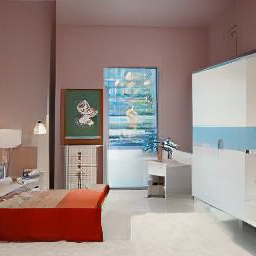

In [6]:
import torch
from diffusers import ConsistencyModelPipeline
from IPython.display import display

device = "cuda"
# Load the cd_bedroom256_lpips checkpoint.
model_id_or_path = "openai/diffusers-cd_bedroom256_lpips"
pipe = ConsistencyModelPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe.to(device)

# + pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

# Multistep sampling
# Timesteps can be explicitly specified; the particular timesteps below are from the original GitHub repo:
# https://github.com/openai/consistency_models/blob/main/scripts/launch.sh#L83
for _ in range(1):
    image = pipe(timesteps=[17, 0]).images[0]
    display(image)


In [7]:
pipe.scheduler


CMStochasticIterativeScheduler {
  "_class_name": "CMStochasticIterativeScheduler",
  "_diffusers_version": "0.33.1",
  "clip_denoised": true,
  "num_train_timesteps": 40,
  "rho": 7.0,
  "s_noise": 1.0,
  "sigma_data": 0.5,
  "sigma_max": 80.0,
  "sigma_min": 0.002
}

In [9]:
pipe.scheduler.set_timesteps(18, device=device)
all_ts = pipe.scheduler.timesteps.tolist()
print(all_ts)


[1095.5066586684702, 1024.0748074975224, 949.6026988007329, 871.8199868526737, 790.4185817686283, 705.0452789277747, 615.2924965091629, 520.6865067232033, 420.6723001352866, 314.5938566767729, 201.66804188748551, 80.94948482281791, -48.71758050454953, -188.76678568058682, -341.00652023050765, -507.763125356554, -692.0997726810987, -898.1647678077132]
